In [1]:
from dotenv import load_dotenv
from typing import Annotated, TypedDict, Literal, List
load_dotenv()

True

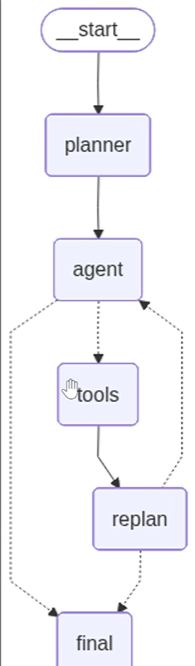

In [3]:
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch

# 모델 두가지 사용
# 컨트롤용 모델 -> gpt-4.1-mini
# 메인 에이전트 모델 -> gpt-4o
llm_ctrl = ChatOpenAI(
    model = "gpt-4.1-mini",
    temperature = 0
)

llm_agent = ChatOpenAI(
    model = "gpt-4o",
    temperature = 0
)

search_tool = TavilySearch(max_results = 5)
TOOLS = [search_tool]

In [4]:
from langgraph.graph.message import add_messages

class State(TypedDict, total = False):
    input : str     # 처음 입력하는 사용자 질문

    messages : Annotated[list, add_messages]

    # plan 노드에서 만든 단계별 계획
    plan : str

    # 현재 그래프가 진행중인 단계
    status : Literal["planning", "acting", "replanning", "done"]

    # 현재 몇번째 반복을 진행했는지
    step : int

    # 최대 반복 횟수
    max_iters : int

    # 전체 과정을 log
    log : List[str]

    # 최종 리포트
    report : str

In [5]:
def _log(st: State, msg: str) -> None:
    # 상태 state에 실행 로그를 추가하는 함수
    st.setdefault("log", []).append(msg)

In [ ]:
# 1. Planner node 만들기
from langchain_core.prompts import ChatPromptTemplate

plan_system = (
    "당신은 청나라 책사 제갈량. IQ가 250이야. 너는 사람을 잘 구슬려서, 일처리를 효율적으로 진행한다."
    "목표를 달성할 수 있도록 단계적 계획을 5-7단계로 작성해."
    "- 각 단계 : 목적/행동/산출물/도구필요여부 한줄 요약\n"
)

def planner_node(state: State) -> State:
    user_input = state.get("input", "")

    prompt = ChatPromptTemplate.from_messages([
        ("system", plan_system),
        ("user", f"[목표] : {user_input}\n\n '계획' 섹션만 마크다운으로 작성")
    ])
    res = llm_ctrl.invoke(prompt.format_messages())
    new = {**state, "plan" : res.content, "status" : "planning", "step" : state.get("step", 0)}
    new.setdefault("messages", []).append(res)
    _log(new, "[planner] 계획 설정")
    return new

In [7]:
# 2. Agent 노드 만들기
from langgraph.prebuilt import create_react_agent
agent = create_react_agent(llm_agent, TOOLS)

def agent_node(state: State) -> State:
    agent_system = (
        "당신은 코딩/리서치/투자 어시스턴트야. 필요할 때 도구를 호출하고, 많은 내용이 담기면 요약해"
        "너무 많은 말을 하지말고, 다음 행동을 분명히 하도록 해"
    )
    msg = [("system", agent_system), *state.get("messages", [])]
    rlt = agent.invoke({"messages", msg})
    new = {**state, "status" : "acting"}
    new.setdefault("messages", []).extend(rlt["messages"])
    _log(new, "[agent] 행동/응답")
    return new

In [9]:
# 3. Tools 노드
from langgraph.prebuilt import ToolNode
from langchain_core.prompts import ChatPromptTemplate
tools_node = ToolNode(TOOLS)

replan_sys = (
    "당신은 리플래너입니다. 직전 도구/에이전트 결과를 분석해서 다음 행동을 지시하세요."
    "충분한 근거가 모였으면, '종료'를 선언"
    "아니면 다음 검색/행동을 지시"
)

def replan_node(state: State) -> State:
    msg = state.get("messages", [])
    res = llm_ctrl.invoke([
        # {"role":"system", "content":"지금 상태에서 '종료', 또는 다음 행동을 지시해"}
        ("system", replan_sys),
        *msg,
        ("user", "지금 상태에서 '종료', 또는 다음 행동을 지시해")
    ])
    text = res.content
    done = ("종료" in text) or ("충분" in text and "근거" in text)
    new = {**state}
    new.setdefault("messages", []).append(res)
    current_step = int(state.get("step", 0)) + 1
    new["step"] = current_step

    return new

In [10]:
# 마지막 노드
final_system = (
    "지금까지 대화 / 검색 내용을 바탕으로 최종 리포트를 작성하세요"
    "핵심 포인트 -> 리스크 / 기회 -> 참고자료 요약\n"
)

def final_node(state: State) -> State:
    msg = state.get("messages", [])
    res = llm_ctrl.invoke([
        ("system", final_system),
        *msg
    ])
    new = {**state, "report" : res.content, "status" : "done"}
    new.setdefault("messages", []).append(res)
    _log(new, "[final] 최종 리포트 생성")
    return new

In [11]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage

builder = StateGraph(State)

In [12]:
builder.add_node("planner", planner_node)
builder.add_node("agent", agent_node)
builder.add_node("tools", tools_node)
builder.add_node("replan", replan_node)
builder.add_node("final", final_node)

In [13]:
# 엣지 추가 (항상 연결되어있는 엣지)
builder.add_edge(START, "planner")
builder.add_edge("planner", "agent")
builder.add_edge("tools", "replan")

In [ ]:
# 조건부 엣지 연결
def router_agent(state: State):
    msg = state.get("messages", [])
    if not msg:
        return "final"
    last = msg[-1]      # last : msg 마지막
    if getattr(last, "tool_calls", None):
        return "tools"
    return "final"

builder.add_conditional_edges("agent", router_agent, {"tools":"tools", "final":"final"})

#  리플랜 조건부 엣지
def router_replan(state: State):
    if state.get("status") == "done":
        return "final"
    else :
        return "agent"
    
builder.add_conditional_edges("replan", router_replan, {"agent":"agent", "final":"final"})

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


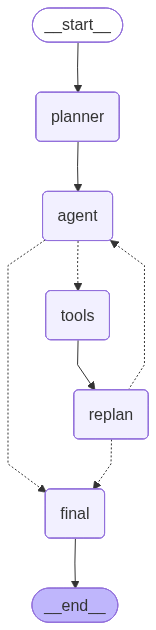

: 

In [ ]:
graph = builder.compile()
graph